In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df=pd.read_csv('apple.csv')
df

,Date,Close/Last,Volume,Open,High,Low
0,12/19/2024,$249.79,60882260,$247.50,$252.00,$247.0949
1,12/18/2024,$248.05,56774100,$252.16,$254.28,$247.74
2,12/17/2024,$253.48,51356360,$250.08,$253.83,$249.78
3,12/16/2024,$251.04,51694750,$247.99,$251.38,$247.65
4,12/13/2024,$248.13,33155290,$247.815,$249.2902,$246.24
...,...,...,...,...,...,...
1253,12/27/2019,$72.45,146371760,$72.78,$73.4925,$72.03
1254,12/26/2019,$72.4775,93336000,$71.205,$72.495,$71.175
1255,12/24/2019,$71.0675,48478840,$71.1725,$71.2225,$70.7299
1256,12/23/2019,$71.00,98711520,$70.1325,$71.0625,$70.0934


In [3]:
df = df[['Date', 'Close/Last']]

In [4]:
df=df.rename(columns={'Close/Last': 'close'})

In [5]:
df['close'] = df['close'].str.replace('$', '').astype(float)

In [6]:
df= df.iloc[::-1].reset_index(drop=True)
df

,Date,close
0,12/20/2019,69.8600
1,12/23/2019,71.0000
2,12/24/2019,71.0675
3,12/26/2019,72.4775
4,12/27/2019,72.4500
...,...,...
1253,12/13/2024,248.1300
1254,12/16/2024,251.0400
1255,12/17/2024,253.4800
1256,12/18/2024,248.0500


In [7]:
def to_date(s):
    split=s.split('/')
    month,day,year=int(split[0]),int(split[1]),int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date']=df['Date'].apply(to_date)
df

,Date,close
0,2019-12-20,69.8600
1,2019-12-23,71.0000
2,2019-12-24,71.0675
3,2019-12-26,72.4775
4,2019-12-27,72.4500
...,...,...
1253,2024-12-13,248.1300
1254,2024-12-16,251.0400
1255,2024-12-17,253.4800
1256,2024-12-18,248.0500


In [8]:
df.index = df.pop('Date')
df

,close
Date,
2019-12-20,69.8600
2019-12-23,71.0000
2019-12-24,71.0675
2019-12-26,72.4775
2019-12-27,72.4500
...,...
2024-12-13,248.1300
2024-12-16,251.0400
2024-12-17,253.4800


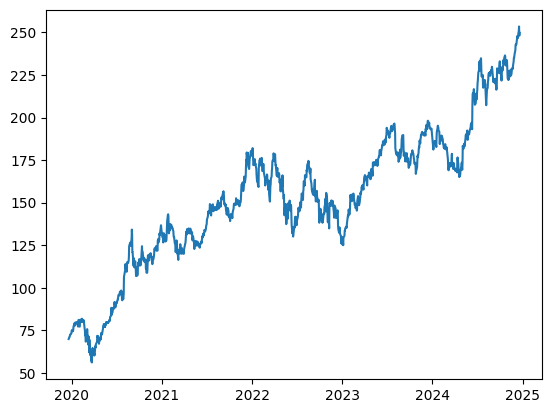

In [9]:
plt.plot(df.index,df['close'])


In [19]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = to_date(first_date_str)
  last_date  = to_date(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df
windowed_df = df_to_windowed_df(df, 
                                '12/26/2019', 
                                '12/19/2022', 
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2019-12-26,69.8600,71.0000,71.0675,72.4775
1,2019-12-27,71.0000,71.0675,72.4775,72.4500
2,2019-12-30,71.0675,72.4775,72.4500,72.8800
3,2019-12-31,72.4775,72.4500,72.8800,73.4125
4,2020-01-02,72.4500,72.8800,73.4125,75.0875
...,...,...,...,...,...
747,2022-12-13,142.6500,142.1600,144.4900,145.4700
748,2022-12-14,142.1600,144.4900,145.4700,143.2100
749,2022-12-15,144.4900,145.4700,143.2100,136.5000
750,2022-12-16,145.4700,143.2100,136.5000,134.5100


In [20]:
def to_date_x_y(windowed_df):
    df_np=windowed_df.to_numpy()
    dates=df_np[:,0]
    middle_mat=df_np[:,1:-1]
    x=middle_mat.reshape(len(dates),middle_mat.shape[1],1)
    y=df_np[:,-1]
    return dates,x.astype(np.float32),y.astype(np.float32)

dates,x,y=to_date_x_y(windowed_df)
dates.shape,x.shape,y.shape

((752,), (752, 3, 1), (752,))

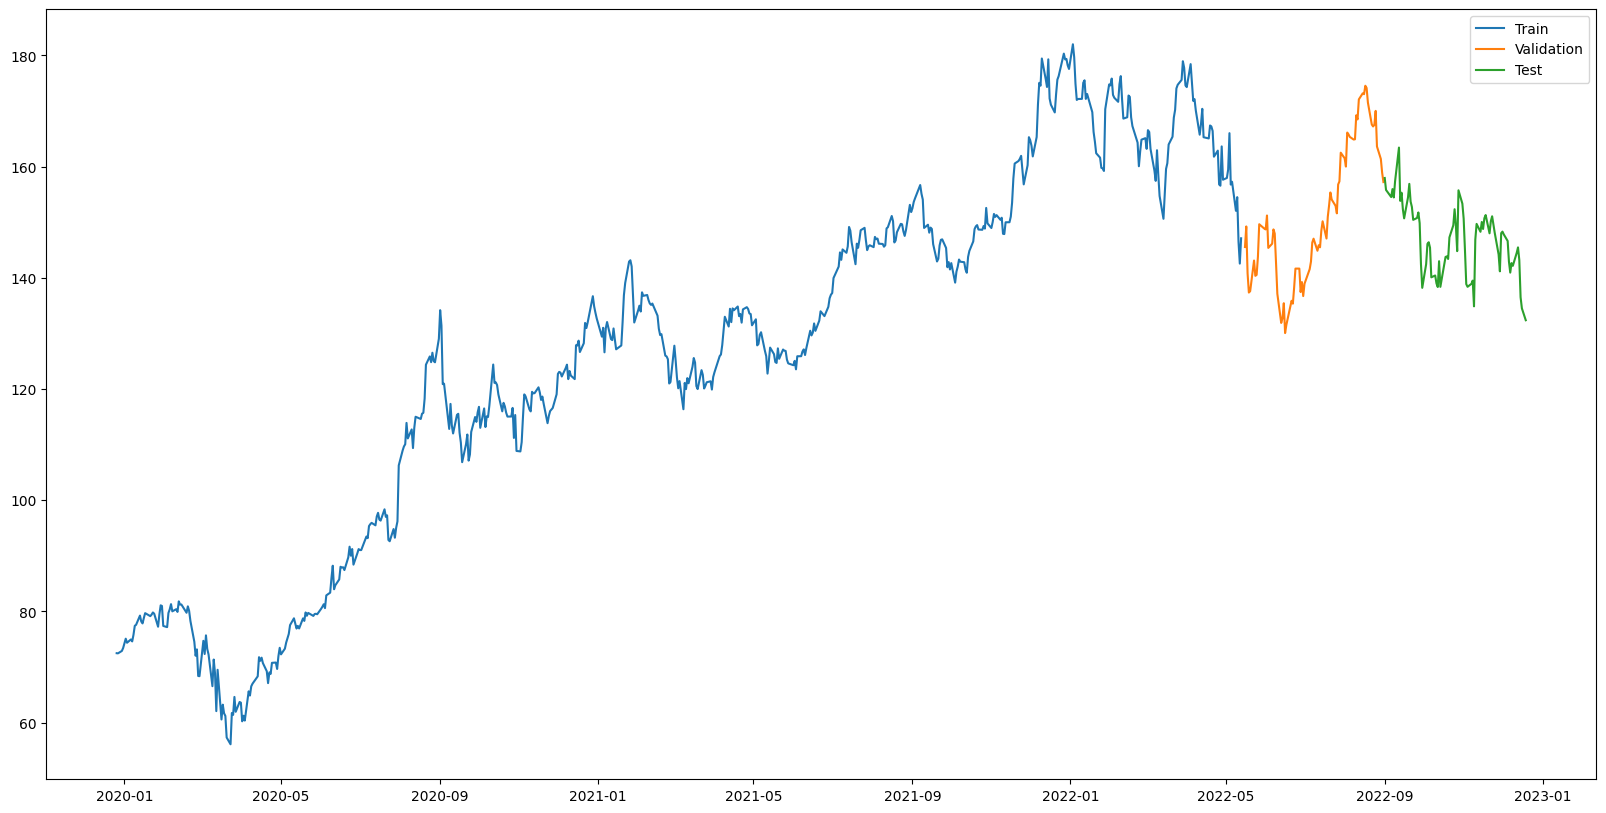

In [41]:
q_80=int(len(dates)*.8)
q_90=int(len(dates)*.9)

dates_train,x_train,y_train=dates[:q_80],x[:q_80],y[:q_80]

dates_val,x_val,y_val=dates[q_80:q_90],x[q_80:q_90],y[q_80:q_90]

dates_test,x_test,y_test=dates[q_90:],x[q_90:],y[q_90:]
plt.figure(figsize=(20,10))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [42]:
model=Sequential([
    layers.Input((3,1)),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(32,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.01),
              metrics=['mean_absolute_error'])
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 13477.4590 - mean_absolute_error: 108.9855 - val_loss: 172.7006 - val_mean_absolute_error: 11.6270
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2064.0803 - mean_absolute_error: 36.1599 - val_loss: 1377.7417 - val_mean_absolute_error: 35.0264
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1106.1556 - mean_absolute_error: 27.0007 - val_loss: 1281.7423 - val_mean_absolute_error: 33.6282
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1073.2974 - mean_absolute_error: 27.1864 - val_loss: 973.5184 - val_mean_absolute_error: 28.6816
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1086.4814 - mean_absolute_error: 26.9710 - val_loss: 601.2743 - val_mean_absolute_error: 21.2224
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1042.7585 - mean_absolute_error: 26.1683 - val_loss: 727.4705 - val_mean_absolute_error: 24.0129
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


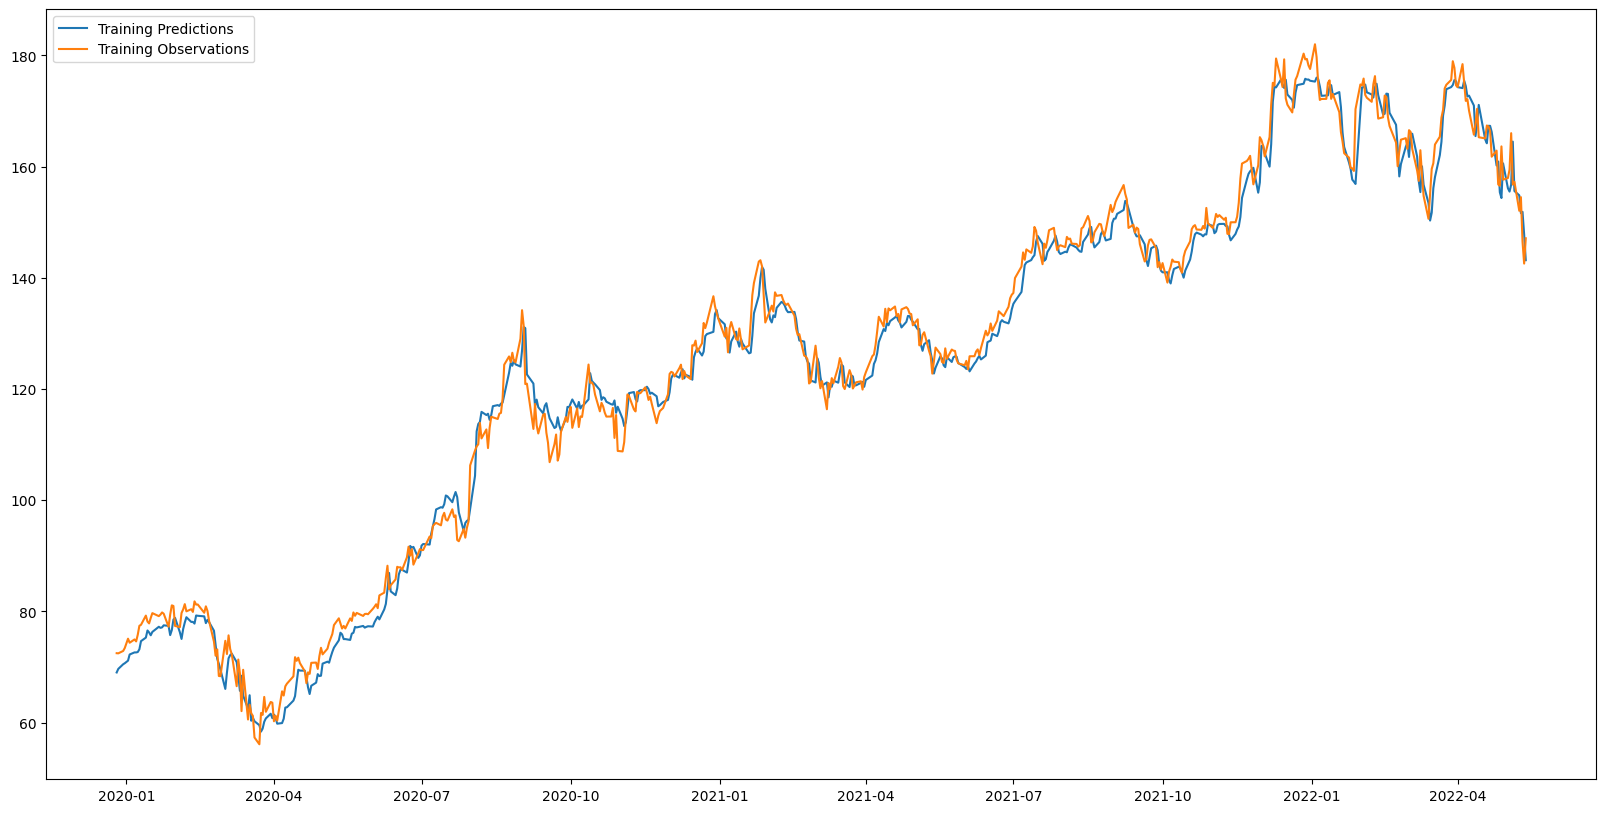

In [43]:
train_predictions = model.predict(x_train).flatten()
plt.figure(figsize=(20,10))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


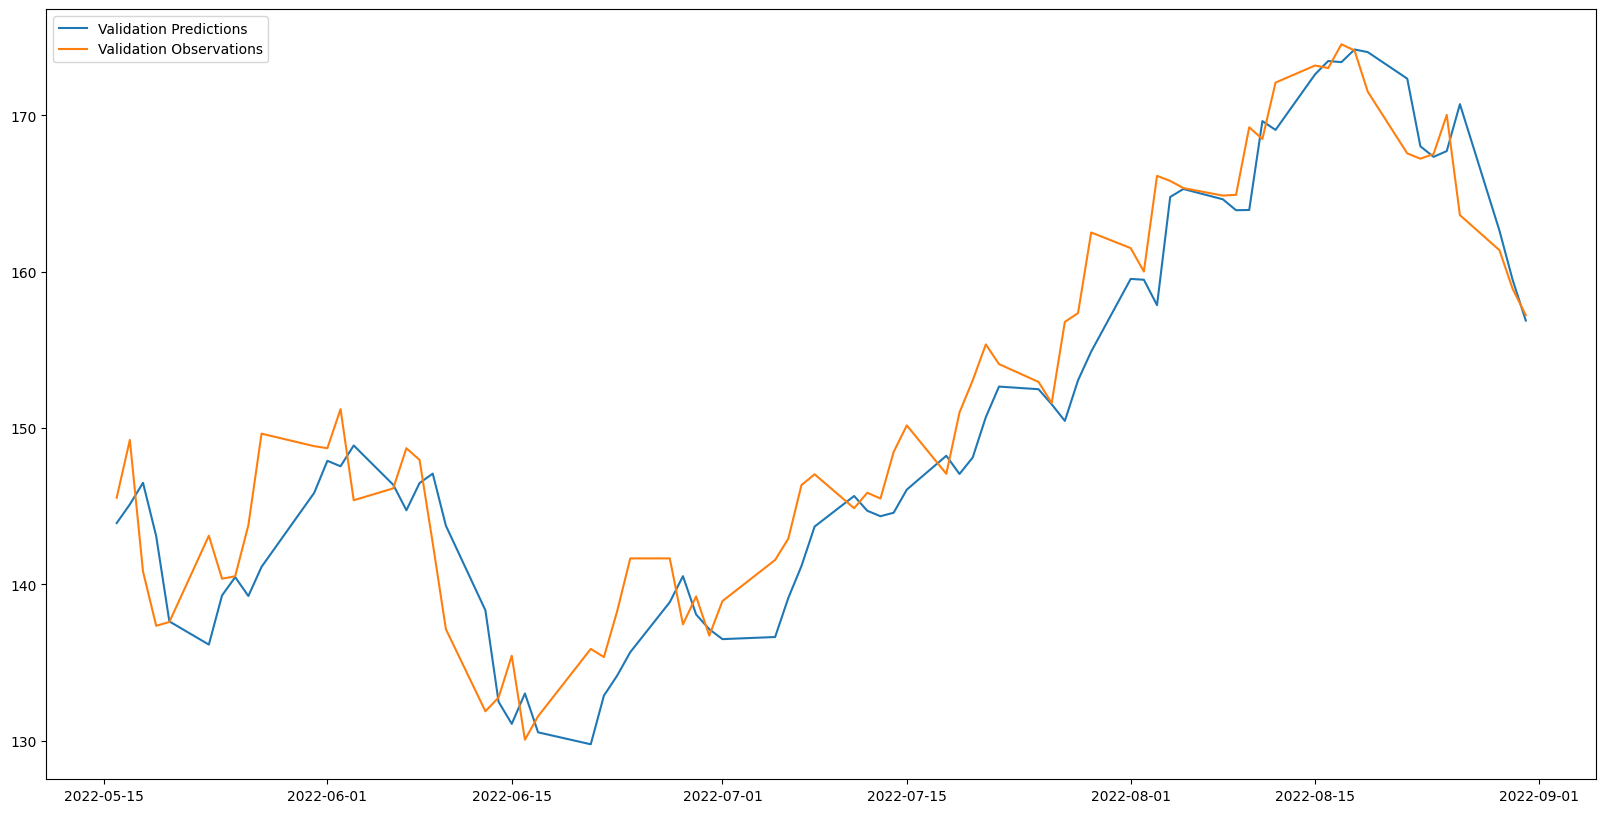

In [44]:
val_predictions = model.predict(x_val).flatten()
plt.figure(figsize=(20,10))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


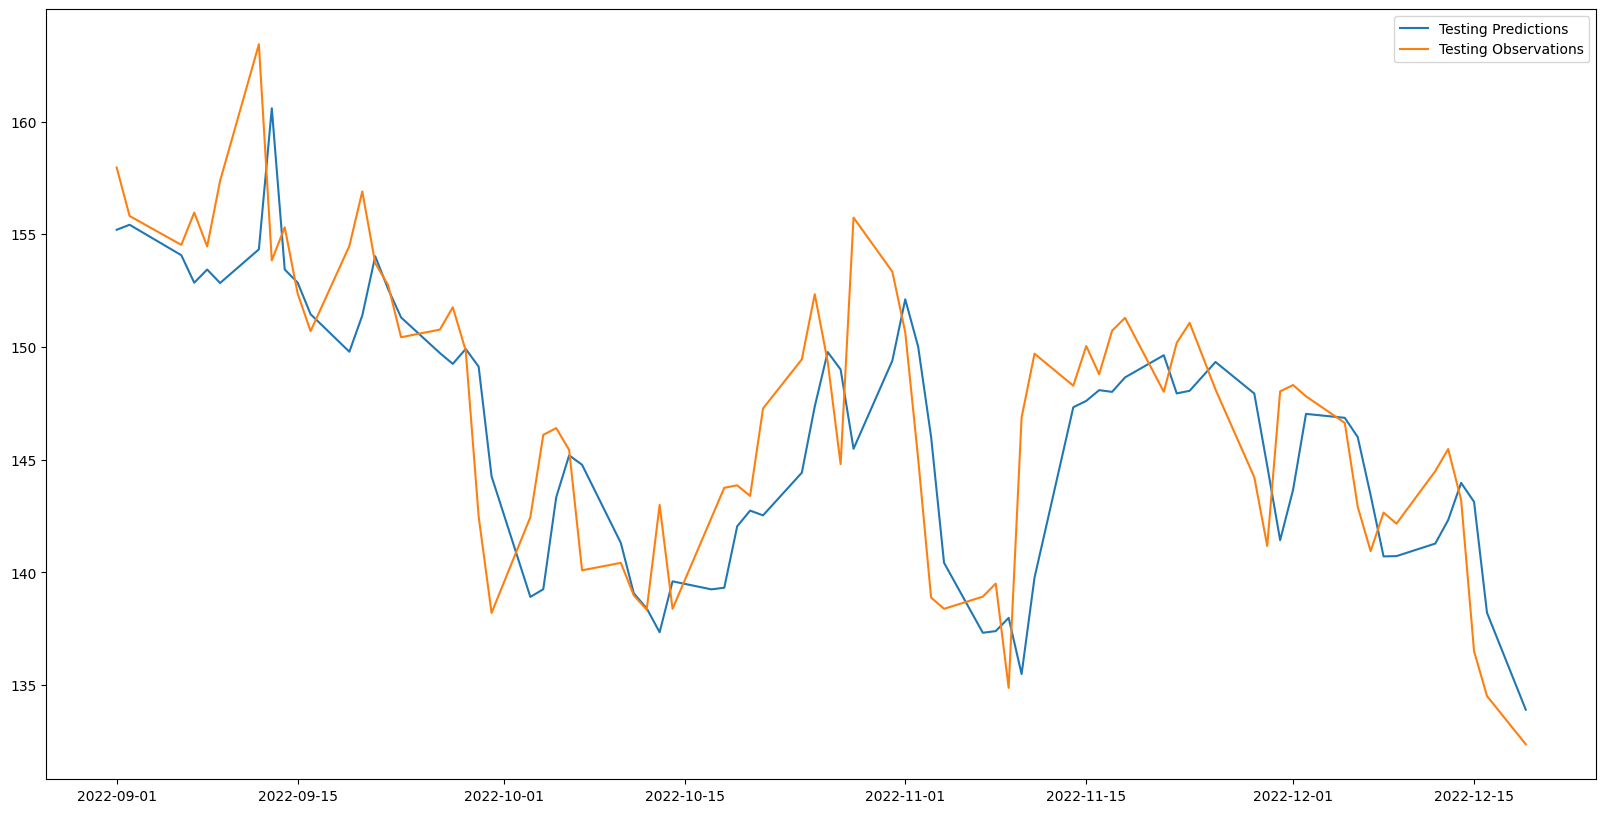

In [45]:
test_predictions = model.predict(x_test).flatten()
plt.figure(figsize=(20,10))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

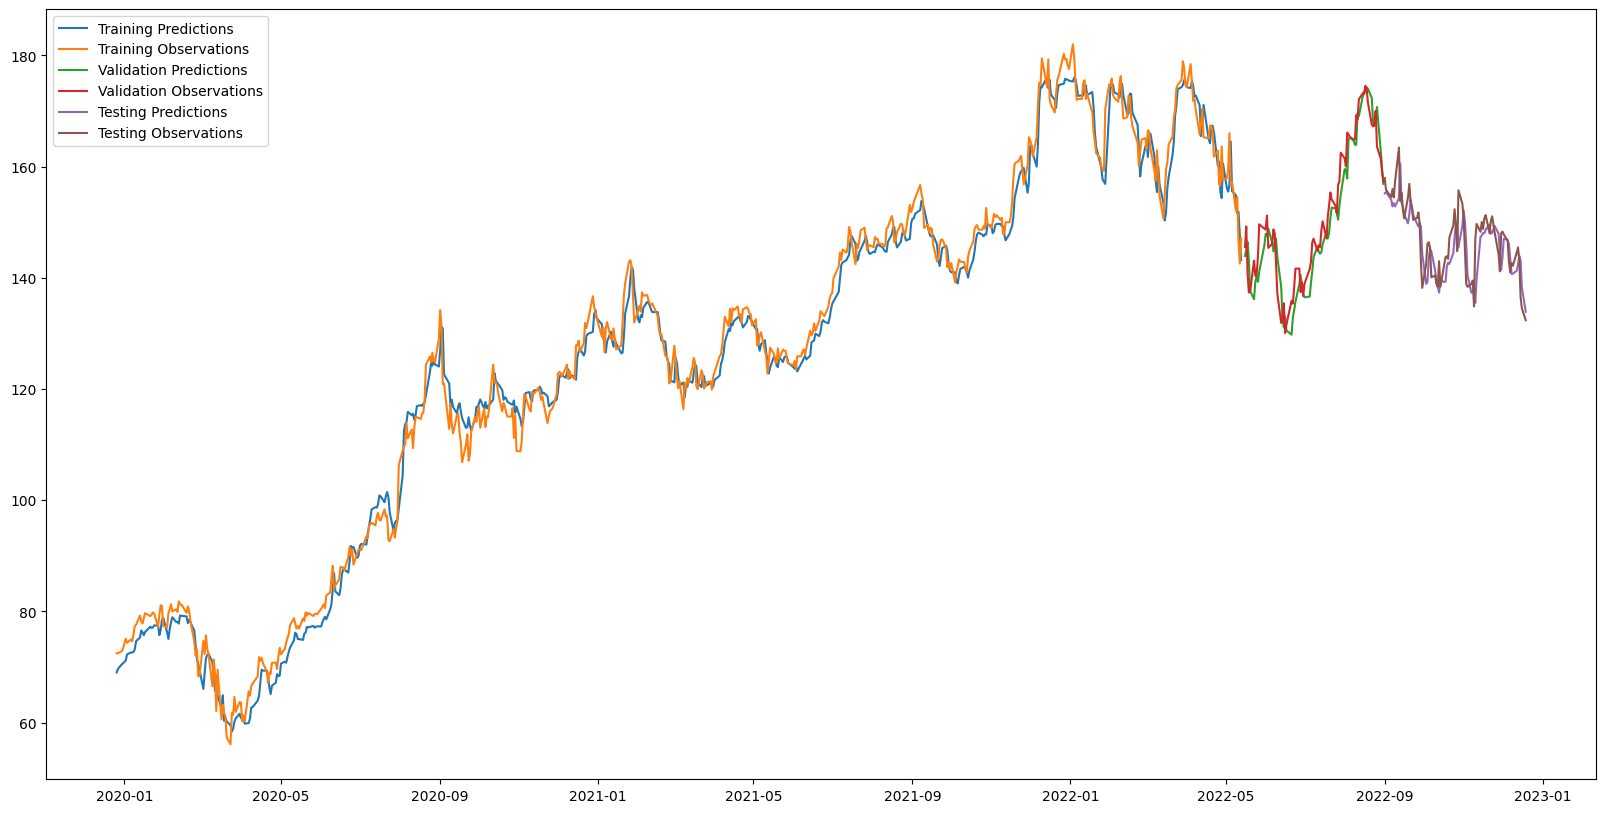

In [46]:
plt.figure(figsize=(20,10))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])